In [89]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error, f1_score

from scipy.stats import stats 
from scipy.stats import chi2_contingency



In [69]:
df = pd.read_csv('C:/Users/82108/Notebook/EP_1_data/m1.csv')
df.head() 

,성별,연령,병원 도착 전 자발순환 회복 여부,병원 도착 전 급성심장정지 목격 여부,목격자유형1,목격자유형2,일반인 심폐소생술 시행여부,발생장소_공공장소,발생장소_비공공장소,급성심장정지 발생 당시 활동,발생원인_질병,발생원인_질병외,응급실 심폐소생술 후 자발순환 회복 여부,응급실 제세동 실시 여부,환자 발생장소_시도
0,1,0,2,1,NaN,3.0,2,NaN,1.0,7,1.0,NaN,1.0,1,서울
1,1,0,2,1,NaN,3.0,2,NaN,1.0,7,1.0,NaN,2.0,1,경기
2,1,0,2,1,NaN,3.0,2,NaN,1.0,7,5.0,NaN,1.0,1,경기
3,1,0,2,1,NaN,3.0,2,NaN,1.0,7,5.0,NaN,1.0,1,경기
4,1,0,2,1,NaN,3.0,2,NaN,1.0,7,5.0,NaN,1.0,1,경기


In [70]:
index = pd.read_csv('C:/Users/82108/Notebook/EP_1_data/m1_index.csv')
index.head() 

,변수,값,의미
0,성별,1,남자
1,성별,2,여자
2,병원 도착 전 자발순환 회복 여부,1,자발순환 회복
3,병원 도착 전 자발순환 회복 여부,2,자발순환 회복 없음
4,병원 도착 전 급성심장정지 목격 여부,1,목격되지 않음


#### ✅ 1. 전처리 - 딕셔너리 & 매핑 

In [71]:
# 1) 인덱스 딕셔너리

dic ={}
for name in index['변수'].unique() : 
    target = index[index['변수'] == name]

    key_value = {}
    for key, value in target.iloc[:,1:].values : 
        key_value[key] = value

    dic[name] = key_value

In [72]:
# 2) Mapping 
df1 = df.copy()

for col in df1.columns : 
    if col in dic.keys() : 
        df1[col] = df1[col].map(dic[col])
    else : 
        df1[col] = df1[col].map(lambda x : x)

In [73]:
# 3) 
df1['목격자'] = df1['목격자유형1'].fillna(df1['목격자유형2'])
df1['발생장소'] = df1['발생장소_공공장소'].fillna(df1['발생장소_비공공장소'])
df1['발생원인'] = df1['발생원인_질병'].fillna(df1['발생원인_질병외'])

df2 = df1.drop(columns = ['목격자유형1','목격자유형2','발생장소_공공장소','발생장소_비공공장소','발생원인_질병','발생원인_질병외'], axis = 1)


#### ✅ 2. EDA 

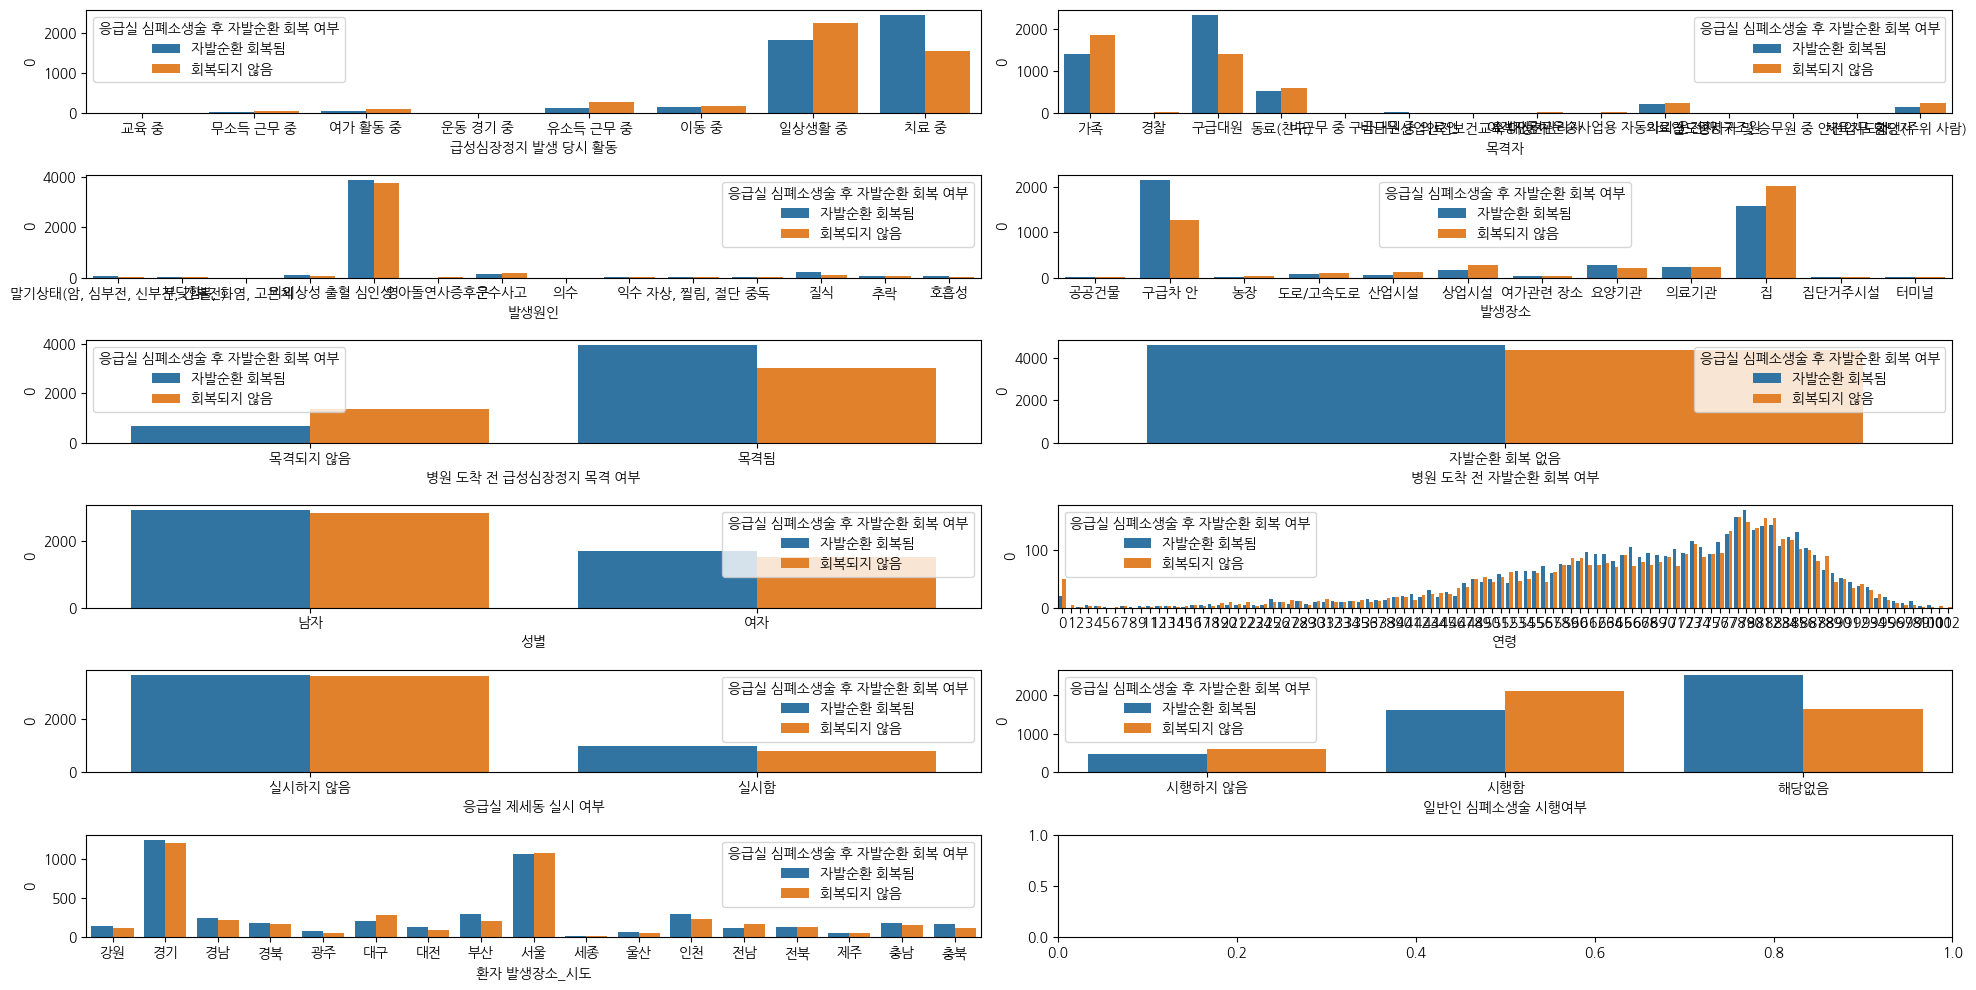

In [74]:
# 일반인 심폐 소생술 시행 여부별 
df2['일반인 심폐소생술 시행여부'] = df2['일반인 심폐소생술 시행여부'].apply(lambda x : '해당없음' if x == '해당없음(근무 중인 구급대원 및 의료인이 목격자인 경우)' else x) 

fig, axes = plt.subplots(6,2, figsize = (20, 10))

for i, axes in enumerate(axes.flat[:len(df2.columns.difference(['응급실 심폐소생술 후 자발순환 회복 여부']))]) : 
    col_i = df2.columns.difference(['응급실 심폐소생술 후 자발순환 회복 여부'])[i]
    target = df2.groupby([col_i,'응급실 심폐소생술 후 자발순환 회복 여부']).size().reset_index()

    sns.barplot(x = col_i, y = 0 , hue = '응급실 심폐소생술 후 자발순환 회복 여부', data = target, ax = axes)

plt.tight_layout()
plt.show()

##### ✅ 3. 응급실 심폐소생 후 자발 순환 회복 여부와 각 독립변수간 통계적 차이 있는지 검정

In [75]:
y = ['응급실 심폐소생술 후 자발순환 회복 여부']
x_cols = df2.columns.difference(['응급실 심폐소생술 후 자발순환 회복 여부'])

res = []
for col in df2.columns : 
    if col in x_cols : 
        target = pd.crosstab(df2[col], df2['응급실 심폐소생술 후 자발순환 회복 여부'])
        stat, p_val , _, __ =  chi2_contingency(target)
        res.append([col, p_val])

res = pd.DataFrame(res, columns = ['Cols', 'P_value'])
res['check'] = res.apply(lambda x : '귀무가설 기각' if x['P_value'] < 0.05 else '귀무가설 채택', axis = 1)
display(res)
print('''
귀무가설 : 자발 순환 회복여부와 해당 컬럼은 독립이다. (상관이없다)
대립가설 : 자발 순환 회복여부와 해당 컬럼은 독립이 아니다. (상관이있다)

성별, 연령, 병원 도착전 자발 순환 회복 여부는 응급실 심폐 소생술 후 자발 순환 회복 여부와 상관이 없으나,
그 외 컬럼은 유의한 상관이 있다는 점을 알 수 있다. 
''')

,Cols,P_value,check
0,성별,8.548896e-02,귀무가설 채택
1,연령,1.967385e-01,귀무가설 채택
2,병원 도착 전 자발순환 회복 여부,1.000000e+00,귀무가설 채택
3,병원 도착 전 급성심장정지 목격 여부,1.019208e-76,귀무가설 기각
4,일반인 심폐소생술 시행여부,1.118404e-60,귀무가설 기각
5,급성심장정지 발생 당시 활동,3.399277e-63,귀무가설 기각
6,응급실 제세동 실시 여부,2.264996e-05,귀무가설 기각
7,환자 발생장소_시도,3.618110e-08,귀무가설 기각
8,목격자,3.846845e-63,귀무가설 기각
9,발생장소,8.382043e-69,귀무가설 기각



귀무가설 : 자발 순환 회복여부와 해당 컬럼은 독립이다. (상관이없다)
대립가설 : 자발 순환 회복여부와 해당 컬럼은 독립이 아니다. (상관이있다)

성별, 연령, 병원 도착전 자발 순환 회복 여부는 응급실 심폐 소생술 후 자발 순환 회복 여부와 상관이 없으나,
그 외 컬럼은 유의한 상관이 있다는 점을 알 수 있다. 



##### ✅ 4. Modelling 
    1. 데이터의 행의 인덱스(0부터시작)을 기준으로 7로 나눈 나머지가 0 또는 3이면 test, 그렇지 않으면 train
    2. 전처리는 train data에 우선 실시하고 train data에서 했던 전처리 기준으로 test data에도 적용
    3. f1-score, accuracy_score, AUC

In [83]:
train_set = df2[(df2.index % 7 != 0) | (df2.index & 7 != 3)]

# label Encoding 실행 
for col in train_set.columns : 
    if train_set[col].dtypes == 'object' : 
        la = LabelEncoder()
        train_set[col] = la.fit_transform(train_set[col])
    else : 
        train_set[col]


In [84]:
test_set = df2[(df2.index % 7 == 0) | (df2.index & 7 == 3)]
# label Encoding 실행 
for col in test_set.columns : 
    if test_set[col].dtypes == 'object' : 
        la = LabelEncoder()
        test_set[col] = la.fit_transform(test_set[col])
    else : 
        test_set[col]

In [86]:
x_train = train_set.drop(columns = ['응급실 심폐소생술 후 자발순환 회복 여부'], axis = 1)
y_train = train_set['응급실 심폐소생술 후 자발순환 회복 여부']

x_test = test_set.drop(columns = ['응급실 심폐소생술 후 자발순환 회복 여부'], axis = 1)
y_test = test_set['응급실 심폐소생술 후 자발순환 회복 여부']

#### 🎯 Random Forest Classifier
여러 개의 결정트리를 배깅(bagging) 방식으로 결합한 앙상블 학습 모델
   1. 범주형 데이터에 강함: 라벨 인코딩된 값을 숫자로 해석하지 않고, 분할 기준으로만 사용
   2. 비선형 관계 탐지 가능: feature 간 상호작용이 있을 경우도 잘 잡아냄
   3. 과적합 방지: 다수의 트리를 평균내므로 과적합 위험이 낮음
   4. 중요도 추정 가능: 각 feature의 중요도를 제공 → 해석 가능성 증가

#### 🎯  XGBoost Classifier
    1. Gradient Boosting 기반의 강력한 앙상블 모델
    2. 복잡한 패턴 학습에 강함 (비선형 + 변수 간 상호작용 포함)
    3. 결측값 자동 처리, regularization(규제), 조기 종료 등 기능 내장
    4. 대규모 데이터셋에 효율적이며 성능 최적화에 유리
    5. 범주형 데이터도 라벨 인코딩만으로 처리 가능

#### 🎯 Tree 모델 선정 이유
    - 단순 선형 분류 모델(Logistic Regression)은 변수 간 상호작용을 미반영
    - 선형 모델은 선형성을 가정 (독립 변수와 종속 변수 간의 선형관계) 하지만, 데이터는 범주형 데이터로 구성 
    - 원-핫 인코딩시 차원이 매우 커짐에 따라 다중 공선성의 문제 발생 가능

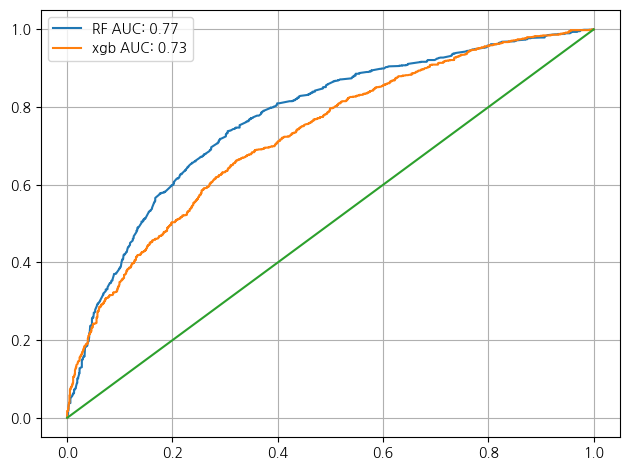

  Model  F1_score  Accuracy_score
0    RF  0.668327        0.704263
1   xgb  0.631063        0.665631


In [93]:

def eval_model(name, model, x_train, x_test, y_train, y_test) : 
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    f1 = f1_score(y_test, pred)
    accuracy = accuracy_score(y_test, pred)

    # ACU 
    pred_proba = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test, pred_proba)

    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    plt.plot(fpr, tpr, label = f'{name} AUC: {auc:.2f}')

    return f1, accuracy 

res = []
model_lst = []
for name, model in [['RF', RandomForestClassifier()] , ['xgb', xgb.XGBClassifier()]] : 
    f1, accuracy = eval_model(name, model, x_train, x_test, y_train, y_test)
    res.append([name, f1, accuracy])
    model_lst.append([name, model])

plt.plot([0,1],[0,1])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(pd.DataFrame(res, columns = ['Model','F1_score', 'Accuracy_score']))

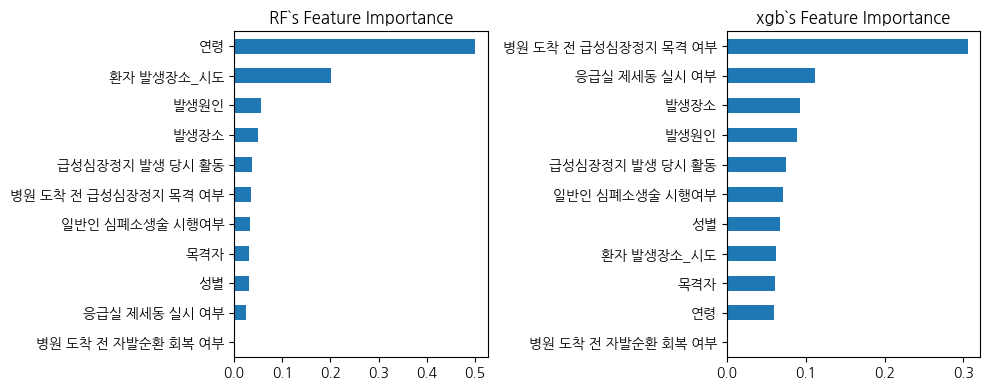

In [105]:
## Feature Importance 
fig, axes = plt.subplots(1,2, figsize = (10, 4))

for axes, (name, model) in zip(axes, model_lst) : 
    features = model.feature_importances_
    cols = model.feature_names_in_
    imp = pd.Series(features ,index = cols).sort_values()
    imp.plot.barh(ax = axes)
    axes.set_title(f'{name}`s Feature Importance')

plt.tight_layout()
plt.show()

#### 🔍 통계
✅ 1. 세 마케팅 전략 간 판매량에 유의미한 차이가 있는지 분산분석을 실시

In [109]:
df = pd.read_csv('C:/Users/82108/Notebook/EP_1_data/s1.csv')
df.head()

,마케팅전략,판매량,만족도
0,A,524.84,8.8
1,A,493.09,8.2
2,A,532.38,8.0
3,A,576.15,9.0
4,A,488.29,9.3


In [112]:
from scipy.stats import shapiro, levene, kruskal

# 1) 정규성 검정 
shapi_res = []
for marketing in df['마케팅전략'].unique() :
    target = df[df['마케팅전략'] == marketing]['판매량']
    stat, p_val = shapiro(target)
    shapi_res.append([marketing, p_val])

print(pd.DataFrame(shapi_res , columns = ['마케팅','P_value']) )

  마케팅   P_value
0   A  0.672051
1   B  0.453425
2   C  0.091206


In [121]:
# 2)등분산 
groups = [group['판매량'].values for name, group in df.groupby('마케팅전략')]

stat, p_val = levene(*groups)
print(p_val)

5.452407609077732e-10


In [126]:
# 3) 비모수 검정 : Anova의 비모수 - Kruskal-Wallis 
stat, p_val = kruskal(* [ group['판매량'].values for name, group in df.groupby(['마케팅전략'])])
print(p_val)

3.0448226717402373e-27


              A             B             C
A  1.000000e+00  6.793820e-07  1.318722e-09
B  6.793820e-07  1.000000e+00  2.670505e-28
C  1.318722e-09  2.670505e-28  1.000000e+00


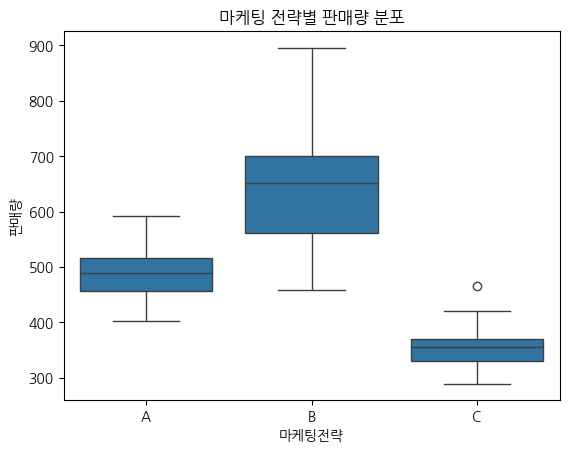


dunn 으로 검정한 결과, A,B,C에 따라 판매량 차이가 유의하다고 나타나며, 이를 박스 플롯의 형태로 
보여준다. 이는 각 마케팅에 따라 판매량이 다르기 때문에, 마케팅 별 전략별 효과 분석이 필요해보인다. 



In [133]:
# 아노바 -> 터키
# 웰치 -> 게임스 하월
# 크루스칼윌리스 Dunn's test를 사용

from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(df['판매량'] , df['마케팅전략'], alpha = 0.05)
#tukey.plot_simultaneous()
#plt.show()

import scikit_posthocs as sp
print(sp.posthoc_dunn(df, val_col='판매량', group_col='마케팅전략'))

sns.boxplot(data=df, x='마케팅전략', y='판매량')
plt.title("마케팅 전략별 판매량 분포")
plt.show()

print('''
dunn 으로 검정한 결과, A,B,C에 따라 판매량 차이가 유의하다고 나타나며, 이를 박스 플롯의 형태로 
보여준다. 이는 각 마케팅에 따라 판매량이 다르기 때문에, 마케팅 별 전략별 효과 분석이 필요해보인다. 
''')